In [1]:
import os
import sys

rootpath = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(rootpath, "src"))

In [2]:
from simcse.models import RobertaForContrastiveLearning

model = RobertaForContrastiveLearning.from_pretrained(
    "princeton-nlp/unsup-simcse-roberta-base",
    output_hidden_states=True,
    pooler_type="cls",
    loss_mlm=False,
    temp=0.05,
)

Some weights of the model checkpoint at princeton-nlp/unsup-simcse-roberta-base were not used when initializing RobertaForContrastiveLearning: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForContrastiveLearning from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForContrastiveLearning from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForContrastiveLearning were not initialized from the model checkpoint at princeton-nlp/unsup-simcse-roberta-base and are newly initialized: ['cl_head.0.weight', 'cl_head.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from sentence_benchmark.data import load_sts12

sts12 = load_sts12(os.path.join(rootpath, "data/STS/STS12-en-test"))

In [4]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")

In [5]:
import torch


def get_inputs_and_outputs(example):
    inputs = tokenizer(example.input, padding=True, return_tensors="pt")
    inputs = {
        "input_ids1": inputs.input_ids[[0]],
        "input_ids2": inputs.input_ids[[1]],
        "attention_mask1": inputs.attention_mask[[0]],
        "attention_mask2": inputs.attention_mask[[1]],
    }
    outputs = model.compute_similarity(**inputs)
    return example, inputs, outputs


with torch.no_grad():
    pipeline = list(map(get_inputs_and_outputs, sts12["MSRpar"]))
print(pipeline)

[(Example(input=['the problem likely will mean corrective changes before the shuttle fleet starts flying again .', 'he said the problem needs to be corrected before the space shuttle fleet is cleared to fly again .'], score=4.4), {'input_ids1': tensor([[    0,   627,   936,   533,    40,  1266, 31378,  1022,   137,     5,
         19463,  7620,  2012,  4731,   456,   479,     2,     1,     1,     1,
             1]]), 'input_ids2': tensor([[    0,   700,    26,     5,   936,   782,     7,    28, 17261,   137,
             5,   980, 19463,  7620,    16,  6049,     7,  3598,   456,   479,
             2]]), 'attention_mask1': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]), 'attention_mask2': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, tensor([0.7956])), (Example(input=['the technology-laced nasdaq composite index .ixic inched down 1 point , or 0.11 percent , to 1,650 .', "the broad standard & poor 's 500 index .spx inched up 3 po

In [6]:
scores = [example.score for example, _, _ in pipeline]
preds = [outputs[0].item() for _, _, outputs in pipeline]

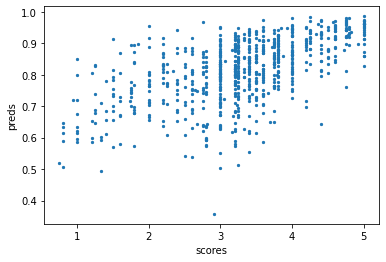

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.patch.set_facecolor("#FFFFFF")
ax.set_xlabel("scores")
ax.set_ylabel("preds")
ax.scatter(scores, preds, s=5)

In [8]:
list(filter(lambda x: x[2][0].item() > 0.90 and x[0].score <= 2, pipeline))

[(Example(input=["in afternoon trading in europe , france 's cac-40 advanced and britain 's ftse 100 each gained 0.7 percent , while germany 's dax index rose 0.6 percent .", "in europe , france 's cac-40 rose 1.3 percent , britain 's ftse 100 declined 0.2 percent and germany 's dax index gained 0.6 percent ."], score=2.0),
  {'input_ids1': tensor([[    0,   179,  1390,  1446,    11,  2287,  2379,  2156,  6664,  2389,
              128,    29, 33624,    12,  1749,  3319,     8,   741,  3961,  1851,
              128,    29, 16935,  1090,   727,   349,  3491,   321,     4,   406,
              135,  2156,   150,   821,  7043,   219,   128,    29,   385,  3631,
             1965,  1458,   321,     4,   401,   135,   479,     2]]),
   'input_ids2': tensor([[    0,   179,  2287,  2379,  2156,  6664,  2389,   128,    29, 33624,
               12,  1749,  1458,   112,     4,   246,   135,  2156,   741,  3961,
             1851,   128,    29, 16935,  1090,   727,  1981,   321,     4,   176,
 

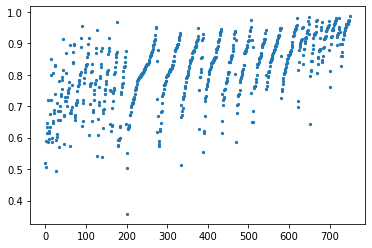

In [9]:
_pipeline = sorted(pipeline, key=lambda x: (x[0].score, x[2][0].item()))
fig, ax = plt.subplots()
fig.patch.set_facecolor("#FFFFFF")
ax.scatter(range(len(_pipeline)), [x[2][0].item() for x in _pipeline], s=5)

In [10]:
list(filter(lambda x: x[2].item() < 0.9, _pipeline[-50:]))

[(Example(input=['the computers were reportedly located in the u.s. , canada and south korea .', 'the pcs are scattered across the united states , canada and south korea .'], score=4.75),
  {'input_ids1': tensor([[    0,   627,  7796,    58,  2288,  2034,    11,     5,  1717,     4,
               29,     4,  2156,    64,  2095,     8,  2077,   449, 33594,   479,
                2]]),
   'input_ids2': tensor([[    0,   627,   181, 11365,    32, 12827,   420,     5, 10409,   982,
             2156,    64,  2095,     8,  2077,   449, 33594,   479,     2,     1,
                1]]),
   'attention_mask1': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
   'attention_mask2': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])},
  tensor([0.7608])),
 (Example(input=["prosecutors contended that mr. durst had plotted the murder to assume mr. black 's identity .", "prosecutors maintained that durst murdered black to try to assume black 's identi

In [14]:
import itertools

pipeline_max = list(
    itertools.accumulate(pipeline, lambda x, y: max(x, y, key=lambda x: x[2][0].item()))
)

In [15]:
pipeline_max = set(pipeline_max)

TypeError: unhashable type: 'list'

In [18]:
pipeline_max[2]

(Example(input=['" it \'s a huge black eye , " said publisher arthur ochs sulzberger jr . , whose family has controlled the paper since 1896 .', '" it \'s a huge black eye , " arthur sulzberger , the newspaper \'s publisher , said of the scandal .'], score=3.6),
 {'input_ids1': tensor([[    0,   113,    24,   128,    29,    10,  1307,   909,  2295,  2156,
              22,    26, 10710,  4709, 42864,  1021,   611,    29, 26648,   329,
           11178,  1236,   338,   479,  2156,  1060,   284,    34,  4875,     5,
            2225,   187, 42773,   479,     2]]),
  'input_ids2': tensor([[    0,   113,    24,   128,    29,    10,  1307,   909,  2295,  2156,
              22,  4709, 42864, 26648,   329, 11178,  2156,     5,  2924,   128,
              29, 10710,  2156,    26,     9,     5,  4220,   479,     2,     1,
               1,     1,     1,     1,     1]]),
  'attention_mask1': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 